In [69]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

# from matplotlib.font_manager import FontProperties
# from matplotlib.ticker import MaxNLocator
# import matplotlib
# fontP = FontProperties()
# fontP.set_size('xx-small')
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['grid.alpha'] = 0.5
# plt.rc('grid', linestyle="--", color='grey')
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');
# figsize = (12,8)


plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

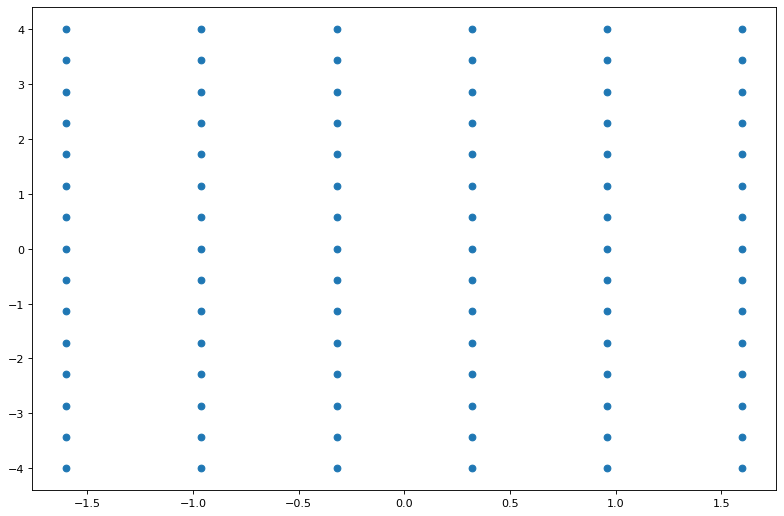

In [70]:
hidden_u = []
m = 100
dim = 2
bounds = [1.6, 4]
# bounds = [2, 2]
n = 90
batch_n = 90
buff = None
epochs = 15000
tol = 1e-5

x = np.linspace(-bounds[0], bounds[0], 6)
y = np.linspace(-bounds[1], bounds[1], 15)
X, Y = np.meshgrid(x, y)
s = X.shape
data = np.zeros((6*15,dim)) 

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        data[c,0] = X[i,j]
        data[c,1] = Y[i,j]
        c = c+1;

data_points = tf.constant(data, tf.float32) # (n_y, dim)
                   
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

input_RHS =  tf.transpose(tf.convert_to_tensor(vf(data_points), dtype=tf.float32))  # (n_y, dim)

plt.scatter(data_points[:,0], data_points[:,1])
# plt.plot(input_RHS[:,0], input_RHS[:,1])

In [71]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 100)               300       
                                                                 
 tf.math.multiply_7 (TFOpLam  (None, 100)              0         
 bda)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 100       
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 400
Trainable params: 100
Non-trainable para

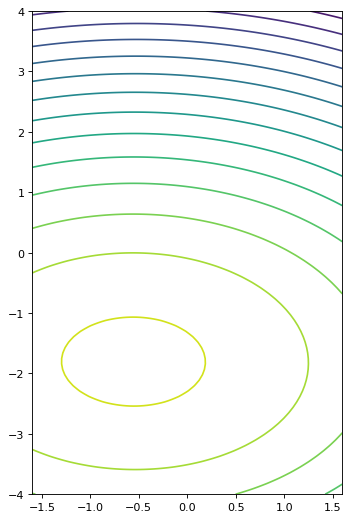

In [72]:
"""Simply plot the Layer without any training to see its initial state"""
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
# just take the 1st row (all of the others are the same)
phi_0 = phi_0[0]
phi_y = intermediate_output1(DT)
# # check that just a random phi_y would not give the same shape
# phi_y = tf.random.uniform((phi_y.shape))

all1 = tf.tensordot(phi_y, phi_0, 1)

all2 = tf.reshape(all1, (n, n))

plt.figure(figsize=(5,8))
plt.contour(x,y, all2, levels=15)
plt.show()

In [73]:
train_dataset_raw = tf.data.Dataset.from_tensor_slices((data_points, input_RHS))
train_dataset_raw = train_dataset_raw.batch(batch_n)

In [74]:
# Custom tensorflow functions for loss and training

# define the part of the loss function implementing the PDE
@tf.function
def grad_loss_eq(gradx, x_batch_train, vf_batch_train):
    # LHS of eq 6.4
    # divided by D
    # g_loss = kb.sum(kb.square(kb.sum(gradx*vf_batch_train,axis=1) + kb.sum(kb.square(x_batch_train),axis=1))) / len(x_batch_train)
    # print('op is {}'.format(tf.math.reduce_sum(gradx*vf_batch_train, axis=2)))
    # print('ep is {}'.format((tf.math.reduce_sum(gradx*vf_batch_train, axis=1) + tf.square(tf.norm(x_batch_train, axis=1))).shape))
    print(gradx.shape)
    print(vf_batch_train.shape)
    print(gradx*vf_batch_train.shape)
    print('--------------')
    inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1)
    # inner_product = tf.reduce_sum(gradx*vf_batch_train)
    target = tf.square(tf.norm(x_batch_train, axis=1))
    # target = tf.square(tf.norm(x_batch_train))
    # print('inner product: {}'.format(inner_product.shape))
    # print('target shape: {}'.format(target.shape))
    # print('ep is {}'.format((inner_product + target)[..., tf.newaxis]))
    loss = tf.reduce_sum(tf.abs((inner_product + target))) / len(x_batch_train)
    # g_loss = tf.reduce_sum(tf.square(tf.norm(tf.math.reduce_sum(gradx*vf_batch_train, axis=1) + tf.square(tf.norm(x_batch_train, axis=1)), axis=1)), axis=0) / len(x_batch_train)
    return loss

# with the division by m, lr should be 0.5 for trainable = False
# opt = tf.keras.optimizers.Adam(learning_rate=0.5)
sgd = tf.keras.optimizers.SGD(learning_rate=10*m, nesterov=True)
gradweight = 1
# this function performs the optimization for a train step
@tf.function
def train_step(x_batch_train, vf_batch_train):

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:
    tape.watch(x_batch_train)

    # evaluate model
    # try trainable = False
    # logits = model(x_batch_train)

    # start gradient recording for derivative w.r.t. x
    with tf.GradientTape() as tapex:

      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      # not sure if training should be false here.
      logits2 = model(x_batch_train)

      # evaluate x-derivative
      gradx = tapex.gradient(logits2, x_batch_train)

      # evaluate PDE part of loss function
      gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
      # this is the w in the loss equation   
      loss_value =  gradweight * gloss

    # evaluate derivative w.r.t. model parameters
    #changed this
  grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent optimizer
    #changed this
  # opt.apply_gradients(zip(grads, model.trainable_weights))
  sgd.apply_gradients(zip(grads, model.trainable_weights))

  return(loss_value,gloss)


@tf.function
def test_step(x_test, vf_test):

  # y_pred = model(x_test, training=False)

  with tf.GradientTape() as tapex:

    tapex.watch(x_test)
    # not sure if training should be false here.
    logits2 = model(x_test, training =False)

    # evaluate x-derivative
    #changed this
  gradx = tapex.gradient(logits2, x_test)

  loss = grad_loss_eq(gradx, x_test, vf_test)
  return gradweight * loss

In [75]:
def custom_training_loop(epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    start = time.perf_counter()

    # loop through the epochs
    for epoch in range(epochs):

        # initialize error variables, mlv=maximum (L_infty), slv = L_1
        mlv = 0.0
        slv = 0.0
        
        # Iterate over the batches of the dataset
        for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            [loss_value,gloss] = train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())


            # update errors
            # mlv = kb.max([mlv,loss_value],0)
            # mlv = tf.math.reduce_max([mlv,loss_value],0)
            # mlv = tf.math.maximum([mlv,loss_value],0)

            slv = slv + loss_value

            # # print log information every 100 steps
            # if step % 100 == 0:
            #   print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv), end = '\r')

        for step, (x_test, vf_test) in enumerate(validation_dataest):
            test_loss = test_step(x_test, vf_test)
            all_test_loss_values.append(test_loss)

        # print log information at end of epoch    
        # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
        # print(loss_value.shape)
        if epoch % int(epochs/5) == 0:
            print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))


        # # terminate if L_infty error is sufficiently small
        # if mlv < tol:
        #     print('op')
        #     break

    print("End of training, time: {:.4f}".format(time.perf_counter() - start))
    return all_loss_values, all_test_loss_values

In [76]:
all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, train_dataset_raw, train_dataset_raw)

(90, 2)
(90, 2)


TypeError: in user code:

    File "/var/folders/zg/b63jfq5j6pzb4_lby01nk6_m0000gn/T/ipykernel_1758/105262591.py", line 54, in train_step  *
        gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
    File "/var/folders/zg/b63jfq5j6pzb4_lby01nk6_m0000gn/T/ipykernel_1758/105262591.py", line 13, in grad_loss_eq  *
        print(gradx*vf_batch_train.shape)

    TypeError: Expected float32 passed to parameter 'y' of op 'Mul', got TensorShape([90, 2]) of type 'TensorShape' instead. Error: Cannot convert TensorShape (90, 2) to dtype <dtype: 'float32'>. Allowed dtypes are tf.int32 and tf.int64.


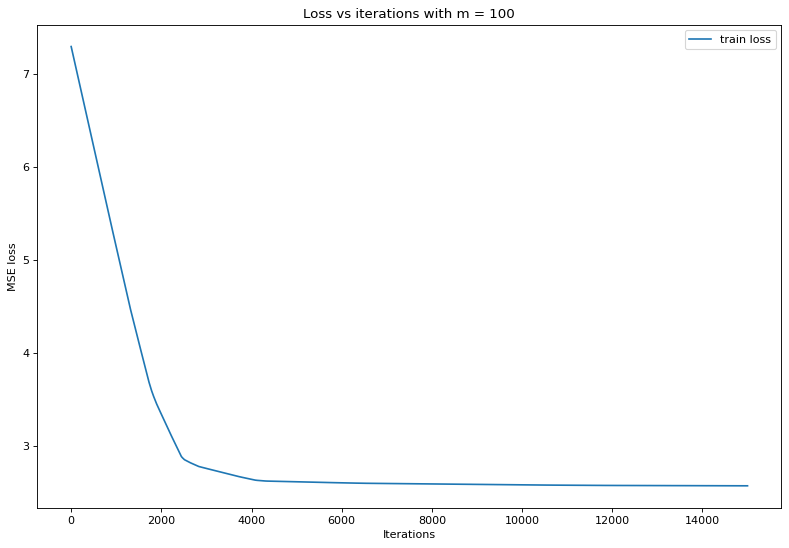

In [ ]:
plt.plot(all_loss_values, label = 'train loss')
# plt.plot(all_test_loss_values, label = 'test loss')
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.legend()
# plt.xscale('log')
plt.show()

Ep shape is (400, 1)
Shapes: x = (20,), X = (20, 20), DT = (400, 2), Ep = (400, 1), Zp = (20, 20)


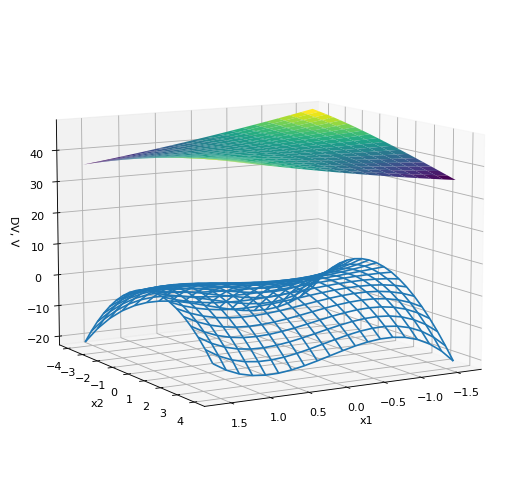

In [ ]:
###### plot result ######

# define resolution
numpoints = 20

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

# x = np.linspace(-1, bounds[0], numpoints)
# y = np.linspace(-1, bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('output_layer').output)
# Ep = intermediate_output2(DT)
print('Ep shape is {}'.format(Ep.shape))
# print('Eq shape is {}'.format(Eq.shape))


# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;


# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, numpoints, numpoints))

print('Shapes: x = {}, X = {}, DT = {}, Ep = {}, Zp = {}'.format(
    x.shape, X.shape, DT.shape, Ep.shape, Zp.shape
))

# define figure
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('DV, V');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
# ax.view_init(-140, 60)
ax.view_init(10, 60)

# plt.savefig('Plots/van_3dplot.pdf')
plt.show()

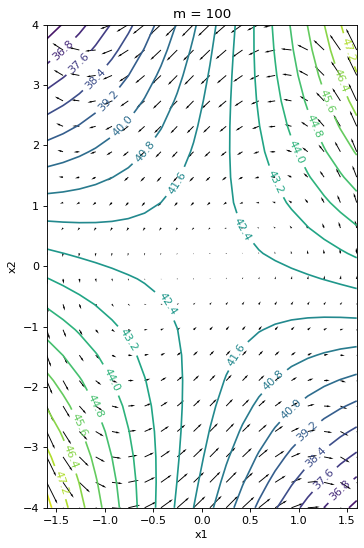

In [ ]:
plt.figure(figsize=(5,8))
cp = plt.contour(x,y,Zp, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.title('m = {}'.format(m))
plt.xlabel('x1')
plt.ylabel('x2')
# plt.savefig('Plots/vanpol2.pdf')
plt.show()